In [14]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader

In [15]:
args = Namespace(
    sequencelength=70,
    dataroot = "/data/sustainbench",
    device="cuda",
    dataset = "southsudan"
)

dataroot = args.dataroot

from earlyrnn import EarlyRNN
nclasses = 4
input_dim = 10
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
import torch
model.load_state_dict(torch.load("../snapshots/model.pth"))
model.eval()

RuntimeError: Error(s) in loading state_dict for EarlyRNN:
	size mismatch for intransforms.0.weight: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for intransforms.0.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for intransforms.1.weight: copying a param with shape torch.Size([64, 13]) from checkpoint, the shape in current model is torch.Size([64, 10]).
	size mismatch for classification_head.projection.0.weight: copying a param with shape torch.Size([7, 64]) from checkpoint, the shape in current model is torch.Size([4, 64]).
	size mismatch for classification_head.projection.0.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([4]).

In [16]:
train_ds = SustainbenchCrops(root=dataroot,partition="train", sequencelength=args.sequencelength, country=args.dataset)
test_ds = SustainbenchCrops(root=dataroot,partition="test", sequencelength=args.sequencelength, country=args.dataset)

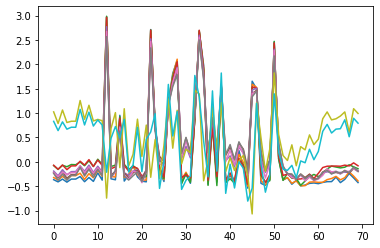

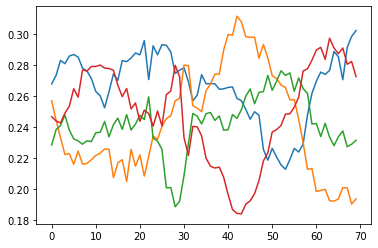

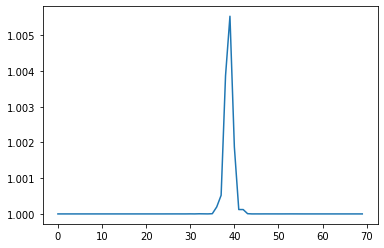

In [17]:
X,y = test_ds[0]
X = X.unsqueeze(0).to(args.device)
log_class_probabilities, probability_stopping = model(X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[0].cpu().detach())
plt.figure()
plt.plot(log_class_probabilities[0].cpu().detach().exp())
plt.figure()
plt.plot(probability_stopping[0].cpu().detach().exp())

In [18]:
import numpy as np
from tqdm.notebook import tqdm
dataloader = DataLoader(test_ds, batch_size=16)
device = args.device
model.eval()

stats = []
losses = []
for batch in tqdm(dataloader):
    X, y_true = batch
    X, y_true = X.to(device), y_true.to(device)

    log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
    stat = {}
    stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
    stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
    stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["targets"] = y_true.cpu().detach().numpy()

    stats.append(stat)


# list of dicts to dict of lists
stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}

  0%|          | 0/440 [00:00<?, ?it/s]

In [19]:
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]

In [20]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score

print(classification_report(y_true, y_pred))

print(f1_score(y_true, y_pred,average="macro"))
print(accuracy_score(y_true, y_pred))
print(cohen_kappa_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69      5675
           1       0.14      0.06      0.08       702
           2       0.00      0.00      0.00       196
           3       0.09      0.54      0.15       461

    accuracy                           0.51      7034
   macro avg       0.27      0.29      0.23      7034
weighted avg       0.70      0.51      0.57      7034

0.2297647486970895
0.5079613306795564
0.063559666434294


In [21]:
t_stop = stats["t_stop"]
t_stop_mean = (t_stop / args.sequencelength).mean()
t_stop_std = (t_stop / args.sequencelength).std()

print(f"average stopping time {t_stop_mean*100:.2f}% +- {t_stop_std*100:.2f}%")

average stopping time 97.73% +- 5.86%
